# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11825
EM iteration 50, llf=-11609, convergence criterion=1.3059e-06
EM converged at iteration 57, llf=-11609, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-11837
EM iteration 50, llf=-11621, convergence criterion=1.3046e-06
EM converged at iteration 57, llf=-11621, convergence criterion=9.9442e-07 < tolerance=1e-06
EM start iterations, llf=-11891
EM iteration 50, llf=-11672, convergence criterion=1.3006e-06
EM converged at iteration 57, llf=-11672, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-11898
EM iteration 50, llf=-11679, convergence criterion=1.3004e-06
EM converged at iteration 57, llf=-11679, convergence criterion=9.9114e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM iteration 50, llf=-11738, convergence criterion=1.3182e-06
EM converged at iteration 58, llf=-11737, convergence criterion=9.7041e-07 < tolerance=1e-06
EM start iterations, llf=-11970
EM iteration 50, llf=-11746, conv

EM start iterations, llf=-12956
EM iteration 50, llf=-12782, convergence criterion=1.0114e-06
EM converged at iteration 51, llf=-12782, convergence criterion=9.7126e-07 < tolerance=1e-06
EM start iterations, llf=-12963
EM iteration 50, llf=-12790, convergence criterion=1.0105e-06
EM converged at iteration 51, llf=-12790, convergence criterion=9.7042e-07 < tolerance=1e-06
EM start iterations, llf=-13008
EM converged at iteration 48, llf=-12831, convergence criterion=9.6793e-07 < tolerance=1e-06
EM start iterations, llf=-13020
EM converged at iteration 48, llf=-12841, convergence criterion=9.6709e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM converged at iteration 47, llf=-12906, convergence criterion=9.7951e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM converged at iteration 47, llf=-12906, convergence criterion=9.7951e-07 < tolerance=1e-06
EM start iterations, llf=-13088
EM converged at iteration 47, llf=-12919, convergence criterion=9.7345e-07 < tolerance=1e-06
E

EM start iterations, llf=-14710
EM converged at iteration 46, llf=-14548, convergence criterion=9.9057e-07 < tolerance=1e-06
EM start iterations, llf=-14718
EM converged at iteration 47, llf=-14553, convergence criterion=9.6045e-07 < tolerance=1e-06
EM start iterations, llf=-14770
EM converged at iteration 46, llf=-14607, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-14770
EM converged at iteration 46, llf=-14607, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-14779
EM converged at iteration 46, llf=-14615, convergence criterion=9.9781e-07 < tolerance=1e-06
EM start iterations, llf=-14835
EM converged at iteration 46, llf=-14670, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-14844
EM converged at iteration 46, llf=-14678, convergence criterion=9.9215e-07 < tolerance=1e-06
EM start iterations, llf=-14893
EM converged at iteration 45, llf=-14727, convergence criterion=9.991e-07 < tolerance=1e-06
E

EM start iterations, llf=-16432
EM converged at iteration 46, llf=-16251, convergence criterion=9.7581e-07 < tolerance=1e-06
EM start iterations, llf=-16440
EM converged at iteration 46, llf=-16259, convergence criterion=9.7737e-07 < tolerance=1e-06
EM start iterations, llf=-16491
EM converged at iteration 46, llf=-16309, convergence criterion=9.7405e-07 < tolerance=1e-06
EM start iterations, llf=-16500
EM converged at iteration 46, llf=-16318, convergence criterion=9.7261e-07 < tolerance=1e-06
EM start iterations, llf=-16549
EM converged at iteration 46, llf=-16366, convergence criterion=9.687e-07 < tolerance=1e-06
EM start iterations, llf=-16556
EM converged at iteration 46, llf=-16373, convergence criterion=9.6875e-07 < tolerance=1e-06
EM start iterations, llf=-16609
EM converged at iteration 46, llf=-16425, convergence criterion=9.6595e-07 < tolerance=1e-06
EM start iterations, llf=-16609
EM converged at iteration 46, llf=-16425, convergence criterion=9.6595e-07 < tolerance=1e-06
E

EM start iterations, llf=-17707
EM iteration 50, llf=-17514, convergence criterion=1.2195e-06
EM converged at iteration 56, llf=-17514, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-17707
EM iteration 50, llf=-17514, convergence criterion=1.2195e-06
EM converged at iteration 56, llf=-17514, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-17726
EM iteration 50, llf=-17533, convergence criterion=1.2187e-06
EM converged at iteration 56, llf=-17533, convergence criterion=9.8352e-07 < tolerance=1e-06
EM start iterations, llf=-17778
EM iteration 50, llf=-17585, convergence criterion=1.213e-06
EM converged at iteration 56, llf=-17585, convergence criterion=9.7914e-07 < tolerance=1e-06
EM start iterations, llf=-17786
EM iteration 50, llf=-17592, convergence criterion=1.2122e-06
EM converged at iteration 56, llf=-17592, convergence criterion=9.7841e-07 < tolerance=1e-06
EM start iterations, llf=-17831
EM iteration 50, llf=-17637, conve

EM start iterations, llf=-18629
EM iteration 50, llf=-18424, convergence criterion=1.2362e-06
EM converged at iteration 56, llf=-18424, convergence criterion=9.9773e-07 < tolerance=1e-06
EM start iterations, llf=-18681
EM iteration 50, llf=-18475, convergence criterion=1.2332e-06
EM converged at iteration 56, llf=-18475, convergence criterion=9.9523e-07 < tolerance=1e-06
EM start iterations, llf=-18688
EM iteration 50, llf=-18482, convergence criterion=1.2323e-06
EM converged at iteration 56, llf=-18482, convergence criterion=9.9455e-07 < tolerance=1e-06
EM start iterations, llf=-18746
EM iteration 50, llf=-18539, convergence criterion=1.2386e-06
EM converged at iteration 56, llf=-18539, convergence criterion=9.9975e-07 < tolerance=1e-06
EM start iterations, llf=-18753
EM iteration 50, llf=-18546, convergence criterion=1.2385e-06
EM converged at iteration 56, llf=-18546, convergence criterion=9.9965e-07 < tolerance=1e-06
EM start iterations, llf=-18805
EM iteration 50, llf=-18597, conv

EM converged at iteration 62, llf=-11668, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-11898
EM iteration 50, llf=-11675, convergence criterion=1.5684e-06
EM converged at iteration 62, llf=-11675, convergence criterion=9.9024e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM iteration 50, llf=-11734, convergence criterion=1.5717e-06
EM converged at iteration 62, llf=-11734, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-11970
EM iteration 50, llf=-11742, convergence criterion=1.5633e-06
EM converged at iteration 62, llf=-11741, convergence criterion=9.8978e-07 < tolerance=1e-06
EM start iterations, llf=-12026
EM iteration 50, llf=-11800, convergence criterion=1.5562e-06
EM converged at iteration 62, llf=-11800, convergence criterion=9.8361e-07 < tolerance=1e-06
EM start iterations, llf=-12026
EM iteration 50, llf=-11800, convergence criterion=1.5562e-06
EM converged at iteration 62, llf=-11800, convergence criterion=9

EM converged at iteration 52, llf=-12826, convergence criterion=9.7921e-07 < tolerance=1e-06
EM start iterations, llf=-13019
EM iteration 50, llf=-12837, convergence criterion=1.0619e-06
EM converged at iteration 52, llf=-12837, convergence criterion=9.7583e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM iteration 50, llf=-12902, convergence criterion=1.0538e-06
EM converged at iteration 52, llf=-12902, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM iteration 50, llf=-12902, convergence criterion=1.0538e-06
EM converged at iteration 52, llf=-12902, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-13087
EM iteration 50, llf=-12916, convergence criterion=1.0591e-06
EM converged at iteration 52, llf=-12916, convergence criterion=9.7513e-07 < tolerance=1e-06
EM start iterations, llf=-13143
EM iteration 50, llf=-12968, convergence criterion=1.0727e-06
EM converged at iteration 52, llf=-12968, convergence criterion=9

EM converged at iteration 58, llf=-14054, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM iteration 50, llf=-14054, convergence criterion=1.3188e-06
EM converged at iteration 58, llf=-14054, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-14224
EM iteration 50, llf=-14066, convergence criterion=1.3246e-06
EM converged at iteration 58, llf=-14065, convergence criterion=9.8683e-07 < tolerance=1e-06
EM start iterations, llf=-14278
EM iteration 50, llf=-14118, convergence criterion=1.305e-06
EM converged at iteration 58, llf=-14118, convergence criterion=9.6921e-07 < tolerance=1e-06
EM start iterations, llf=-14285
EM iteration 50, llf=-14125, convergence criterion=1.2777e-06
EM converged at iteration 57, llf=-14124, convergence criterion=9.7981e-07 < tolerance=1e-06
EM start iterations, llf=-14344
EM iteration 50, llf=-14183, convergence criterion=1.3051e-06
EM converged at iteration 57, llf=-14183, convergence criterion=9.

EM converged at iteration 57, llf=-15153, convergence criterion=9.9317e-07 < tolerance=1e-06
EM start iterations, llf=-15375
EM iteration 50, llf=-15206, convergence criterion=1.2809e-06
EM converged at iteration 57, llf=-15206, convergence criterion=9.9379e-07 < tolerance=1e-06
EM start iterations, llf=-15386
EM iteration 50, llf=-15218, convergence criterion=1.2909e-06
EM converged at iteration 58, llf=-15217, convergence criterion=9.6892e-07 < tolerance=1e-06
EM start iterations, llf=-15436
EM iteration 50, llf=-15267, convergence criterion=1.2999e-06
EM converged at iteration 58, llf=-15267, convergence criterion=9.7564e-07 < tolerance=1e-06
EM start iterations, llf=-15443
EM iteration 50, llf=-15274, convergence criterion=1.2917e-06
EM converged at iteration 58, llf=-15274, convergence criterion=9.6878e-07 < tolerance=1e-06
EM start iterations, llf=-15490
EM iteration 50, llf=-15320, convergence criterion=1.2761e-06
EM converged at iteration 57, llf=-15319, convergence criterion=9

EM converged at iteration 52, llf=-16316, convergence criterion=9.95e-07 < tolerance=1e-06
EM start iterations, llf=-16548
EM iteration 50, llf=-16363, convergence criterion=1.0749e-06
EM converged at iteration 52, llf=-16363, convergence criterion=9.9305e-07 < tolerance=1e-06
EM start iterations, llf=-16556
EM iteration 50, llf=-16371, convergence criterion=1.0726e-06
EM converged at iteration 52, llf=-16371, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-16608
EM iteration 50, llf=-16422, convergence criterion=1.0658e-06
EM converged at iteration 52, llf=-16422, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-16608
EM iteration 50, llf=-16422, convergence criterion=1.0658e-06
EM converged at iteration 52, llf=-16422, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-16619
EM iteration 50, llf=-16434, convergence criterion=1.0678e-06
EM converged at iteration 52, llf=-16434, convergence criterion=9.8

EM converged at iteration 61, llf=-17463, convergence criterion=9.7628e-07 < tolerance=1e-06
EM start iterations, llf=-17706
EM iteration 50, llf=-17512, convergence criterion=1.4204e-06
EM converged at iteration 61, llf=-17512, convergence criterion=9.7101e-07 < tolerance=1e-06
EM start iterations, llf=-17706
EM iteration 50, llf=-17512, convergence criterion=1.4204e-06
EM converged at iteration 61, llf=-17512, convergence criterion=9.7101e-07 < tolerance=1e-06
EM start iterations, llf=-17725
EM iteration 50, llf=-17531, convergence criterion=1.4223e-06
EM converged at iteration 61, llf=-17531, convergence criterion=9.7221e-07 < tolerance=1e-06
EM start iterations, llf=-17778
EM iteration 50, llf=-17583, convergence criterion=1.4144e-06
EM converged at iteration 60, llf=-17583, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-17785
EM iteration 50, llf=-17590, convergence criterion=1.4089e-06
EM converged at iteration 60, llf=-17590, convergence criterion=9

EM converged at iteration 60, llf=-18415, convergence criterion=9.7283e-07 < tolerance=1e-06
EM start iterations, llf=-18628
EM iteration 50, llf=-18421, convergence criterion=1.386e-06
EM converged at iteration 60, llf=-18421, convergence criterion=9.7303e-07 < tolerance=1e-06
EM start iterations, llf=-18680
EM iteration 50, llf=-18472, convergence criterion=1.3819e-06
EM converged at iteration 60, llf=-18472, convergence criterion=9.6987e-07 < tolerance=1e-06
EM start iterations, llf=-18687
EM iteration 50, llf=-18479, convergence criterion=1.3802e-06
EM converged at iteration 60, llf=-18479, convergence criterion=9.6876e-07 < tolerance=1e-06
EM start iterations, llf=-18745
EM iteration 50, llf=-18536, convergence criterion=1.3949e-06
EM converged at iteration 60, llf=-18536, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-18753
EM iteration 50, llf=-18544, convergence criterion=1.3959e-06
EM converged at iteration 60, llf=-18543, convergence criterion=9.

EM start iterations, llf=-11881
EM iteration 50, llf=-11659, convergence criterion=1.4955e-06
EM converged at iteration 61, llf=-11659, convergence criterion=9.7449e-07 < tolerance=1e-06
EM start iterations, llf=-11888
EM iteration 50, llf=-11666, convergence criterion=1.4959e-06
EM converged at iteration 61, llf=-11666, convergence criterion=9.7469e-07 < tolerance=1e-06
EM start iterations, llf=-11952
EM iteration 50, llf=-11725, convergence criterion=1.5022e-06
EM converged at iteration 61, llf=-11725, convergence criterion=9.8173e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM iteration 50, llf=-11733, convergence criterion=1.4942e-06
EM converged at iteration 61, llf=-11733, convergence criterion=9.7698e-07 < tolerance=1e-06
EM start iterations, llf=-12017
EM iteration 50, llf=-11790, convergence criterion=1.4845e-06
EM converged at iteration 61, llf=-11790, convergence criterion=9.6977e-07 < tolerance=1e-06
EM start iterations, llf=-12017
EM iteration 50, llf=-11790, conv

EM start iterations, llf=-13002
EM iteration 50, llf=-12819, convergence criterion=1.1438e-06
EM converged at iteration 54, llf=-12819, convergence criterion=9.6358e-07 < tolerance=1e-06
EM start iterations, llf=-13013
EM iteration 50, llf=-12829, convergence criterion=1.138e-06
EM converged at iteration 53, llf=-12829, convergence criterion=9.9937e-07 < tolerance=1e-06
EM start iterations, llf=-13071
EM iteration 50, llf=-12896, convergence criterion=1.1735e-06
EM converged at iteration 54, llf=-12896, convergence criterion=9.9046e-07 < tolerance=1e-06
EM start iterations, llf=-13071
EM iteration 50, llf=-12896, convergence criterion=1.1735e-06
EM converged at iteration 54, llf=-12896, convergence criterion=9.9046e-07 < tolerance=1e-06
EM start iterations, llf=-13081
EM iteration 50, llf=-12910, convergence criterion=1.1853e-06
EM converged at iteration 55, llf=-12910, convergence criterion=9.6193e-07 < tolerance=1e-06
EM start iterations, llf=-13137
EM iteration 50, llf=-12962, conve

EM start iterations, llf=-14204
EM iteration 50, llf=-14049, convergence criterion=1.2621e-06
EM converged at iteration 56, llf=-14049, convergence criterion=9.8359e-07 < tolerance=1e-06
EM start iterations, llf=-14204
EM iteration 50, llf=-14049, convergence criterion=1.2621e-06
EM converged at iteration 56, llf=-14049, convergence criterion=9.8359e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM iteration 50, llf=-14060, convergence criterion=1.2602e-06
EM converged at iteration 56, llf=-14060, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-14268
EM iteration 50, llf=-14113, convergence criterion=1.2531e-06
EM converged at iteration 56, llf=-14113, convergence criterion=9.758e-07 < tolerance=1e-06
EM start iterations, llf=-14275
EM iteration 50, llf=-14119, convergence criterion=1.2421e-06
EM converged at iteration 56, llf=-14119, convergence criterion=9.6666e-07 < tolerance=1e-06
EM start iterations, llf=-14335
EM iteration 50, llf=-14178, conve

EM start iterations, llf=-15313
EM iteration 50, llf=-15148, convergence criterion=1.26e-06
EM converged at iteration 56, llf=-15148, convergence criterion=9.9023e-07 < tolerance=1e-06
EM start iterations, llf=-15367
EM iteration 50, llf=-15202, convergence criterion=1.2582e-06
EM converged at iteration 56, llf=-15202, convergence criterion=9.8943e-07 < tolerance=1e-06
EM start iterations, llf=-15378
EM iteration 50, llf=-15213, convergence criterion=1.2579e-06
EM converged at iteration 56, llf=-15213, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-15427
EM iteration 50, llf=-15263, convergence criterion=1.2663e-06
EM converged at iteration 56, llf=-15262, convergence criterion=9.9606e-07 < tolerance=1e-06
EM start iterations, llf=-15435
EM iteration 50, llf=-15270, convergence criterion=1.2605e-06
EM converged at iteration 56, llf=-15269, convergence criterion=9.917e-07 < tolerance=1e-06
EM start iterations, llf=-15482
EM iteration 50, llf=-15315, converg

EM start iterations, llf=-16490
EM iteration 50, llf=-16310, convergence criterion=1.1657e-06
EM converged at iteration 54, llf=-16310, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-16539
EM iteration 50, llf=-16358, convergence criterion=1.1573e-06
EM converged at iteration 54, llf=-16358, convergence criterion=9.809e-07 < tolerance=1e-06
EM start iterations, llf=-16547
EM iteration 50, llf=-16365, convergence criterion=1.1558e-06
EM converged at iteration 54, llf=-16365, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-16599
EM iteration 50, llf=-16416, convergence criterion=1.1512e-06
EM converged at iteration 54, llf=-16416, convergence criterion=9.7554e-07 < tolerance=1e-06
EM start iterations, llf=-16599
EM iteration 50, llf=-16416, convergence criterion=1.1512e-06
EM converged at iteration 54, llf=-16416, convergence criterion=9.7554e-07 < tolerance=1e-06
EM start iterations, llf=-16609
EM iteration 50, llf=-16428, conve

EM start iterations, llf=-17647
EM iteration 50, llf=-17458, convergence criterion=1.4753e-06
EM converged at iteration 61, llf=-17457, convergence criterion=9.9335e-07 < tolerance=1e-06
EM start iterations, llf=-17697
EM iteration 50, llf=-17507, convergence criterion=1.4686e-06
EM converged at iteration 61, llf=-17506, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-17697
EM iteration 50, llf=-17507, convergence criterion=1.4686e-06
EM converged at iteration 61, llf=-17506, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-17716
EM iteration 50, llf=-17526, convergence criterion=1.4709e-06
EM converged at iteration 61, llf=-17526, convergence criterion=9.9036e-07 < tolerance=1e-06
EM start iterations, llf=-17768
EM iteration 50, llf=-17578, convergence criterion=1.455e-06
EM converged at iteration 61, llf=-17578, convergence criterion=9.8069e-07 < tolerance=1e-06
EM start iterations, llf=-17775
EM iteration 50, llf=-17585, converg

EM start iterations, llf=-18614
EM iteration 50, llf=-18409, convergence criterion=1.4492e-06
EM converged at iteration 61, llf=-18409, convergence criterion=9.7508e-07 < tolerance=1e-06
EM start iterations, llf=-18619
EM iteration 50, llf=-18415, convergence criterion=1.4495e-06
EM converged at iteration 61, llf=-18415, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-18671
EM iteration 50, llf=-18466, convergence criterion=1.4451e-06
EM converged at iteration 61, llf=-18466, convergence criterion=9.7208e-07 < tolerance=1e-06
EM start iterations, llf=-18678
EM iteration 50, llf=-18473, convergence criterion=1.4433e-06
EM converged at iteration 61, llf=-18473, convergence criterion=9.7098e-07 < tolerance=1e-06
EM start iterations, llf=-18736
EM iteration 50, llf=-18530, convergence criterion=1.454e-06
EM converged at iteration 61, llf=-18529, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-18744
EM iteration 50, llf=-18537, conve

EM converged at iteration 53, llf=-11244, convergence criterion=9.9109e-07 < tolerance=1e-06
EM start iterations, llf=-11415
EM iteration 50, llf=-11296, convergence criterion=1.0971e-06
EM converged at iteration 53, llf=-11296, convergence criterion=9.7766e-07 < tolerance=1e-06
EM start iterations, llf=-11423
EM iteration 50, llf=-11304, convergence criterion=1.0946e-06
EM converged at iteration 53, llf=-11304, convergence criterion=9.7535e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM iteration 50, llf=-11360, convergence criterion=1.0687e-06
EM converged at iteration 52, llf=-11360, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-11490
EM iteration 50, llf=-11369, convergence criterion=1.0564e-06
EM converged at iteration 52, llf=-11369, convergence criterion=9.774e-07 < tolerance=1e-06
EM start iterations, llf=-11548
EM iteration 50, llf=-11422, convergence criterion=1.0864e-06
EM converged at iteration 53, llf=-11422, convergence criterion=9.

EM start iterations, llf=-12534
EM converged at iteration 46, llf=-12408, convergence criterion=9.7381e-07 < tolerance=1e-06
EM start iterations, llf=-12540
EM converged at iteration 46, llf=-12413, convergence criterion=9.737e-07 < tolerance=1e-06
EM start iterations, llf=-12592
EM converged at iteration 46, llf=-12466, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-12606
EM converged at iteration 46, llf=-12478, convergence criterion=9.6874e-07 < tolerance=1e-06
EM start iterations, llf=-12653
EM converged at iteration 46, llf=-12526, convergence criterion=9.623e-07 < tolerance=1e-06
EM start iterations, llf=-12653
EM converged at iteration 46, llf=-12526, convergence criterion=9.623e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM converged at iteration 46, llf=-12537, convergence criterion=9.6364e-07 < tolerance=1e-06
EM start iterations, llf=-12710
EM converged at iteration 46, llf=-12582, convergence criterion=9.5701e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14178
EM converged at iteration 44, llf=-14047, convergence criterion=9.7868e-07 < tolerance=1e-06
EM start iterations, llf=-14230
EM converged at iteration 44, llf=-14099, convergence criterion=9.7681e-07 < tolerance=1e-06
EM start iterations, llf=-14230
EM converged at iteration 44, llf=-14099, convergence criterion=9.7681e-07 < tolerance=1e-06
EM start iterations, llf=-14235
EM converged at iteration 44, llf=-14103, convergence criterion=9.695e-07 < tolerance=1e-06
EM start iterations, llf=-14279
EM converged at iteration 43, llf=-14148, convergence criterion=9.9158e-07 < tolerance=1e-06
EM start iterations, llf=-14285
EM converged at iteration 43, llf=-14154, convergence criterion=9.8784e-07 < tolerance=1e-06
EM start iterations, llf=-14344
EM converged at iteration 44, llf=-14211, convergence criterion=9.9156e-07 < tolerance=1e-06
EM start iterations, llf=-14353
EM converged at iteration 44, llf=-14220, convergence criterion=9.8557e-07 < tolerance=1e-06
E

EM start iterations, llf=-15845
EM converged at iteration 44, llf=-15708, convergence criterion=9.9791e-07 < tolerance=1e-06
EM start iterations, llf=-15894
EM converged at iteration 44, llf=-15756, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-15901
EM converged at iteration 44, llf=-15763, convergence criterion=9.9275e-07 < tolerance=1e-06
EM start iterations, llf=-15951
EM converged at iteration 44, llf=-15813, convergence criterion=9.9211e-07 < tolerance=1e-06
EM start iterations, llf=-15964
EM iteration 50, llf=-15823, convergence criterion=1.2559e-06
EM converged at iteration 57, llf=-15823, convergence criterion=9.758e-07 < tolerance=1e-06
EM start iterations, llf=-16011
EM iteration 50, llf=-15870, convergence criterion=1.2524e-06
EM converged at iteration 57, llf=-15870, convergence criterion=9.7307e-07 < tolerance=1e-06
EM start iterations, llf=-16011
EM iteration 50, llf=-15870, convergence criterion=1.2524e-06
EM converged at iteration 57, llf

EM converged at iteration 56, llf=-16860, convergence criterion=9.9357e-07 < tolerance=1e-06
EM start iterations, llf=-17016
EM iteration 50, llf=-16875, convergence criterion=1.2359e-06
EM converged at iteration 56, llf=-16875, convergence criterion=9.9467e-07 < tolerance=1e-06
EM start iterations, llf=-17068
EM iteration 50, llf=-16928, convergence criterion=1.2338e-06
EM converged at iteration 56, llf=-16928, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-17068
EM iteration 50, llf=-16928, convergence criterion=1.2338e-06
EM converged at iteration 56, llf=-16928, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-17081
EM iteration 50, llf=-16938, convergence criterion=1.2288e-06
EM converged at iteration 56, llf=-16938, convergence criterion=9.8914e-07 < tolerance=1e-06
EM start iterations, llf=-17128
EM iteration 50, llf=-16985, convergence criterion=1.2281e-06
EM converged at iteration 56, llf=-16985, convergence criterion=9

EM converged at iteration 56, llf=-17794, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-17940
EM iteration 50, llf=-17795, convergence criterion=1.2194e-06
EM converged at iteration 56, llf=-17794, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-17948
EM iteration 50, llf=-17802, convergence criterion=1.2184e-06
EM converged at iteration 56, llf=-17802, convergence criterion=9.7998e-07 < tolerance=1e-06
EM start iterations, llf=-18005
EM iteration 50, llf=-17859, convergence criterion=1.2136e-06
EM converged at iteration 56, llf=-17859, convergence criterion=9.7615e-07 < tolerance=1e-06
EM start iterations, llf=-18009
EM iteration 50, llf=-17865, convergence criterion=1.2153e-06
EM converged at iteration 56, llf=-17865, convergence criterion=9.774e-07 < tolerance=1e-06
EM start iterations, llf=-18058
EM iteration 50, llf=-17913, convergence criterion=1.2302e-06
EM converged at iteration 56, llf=-17913, convergence criterion=9.

EM start iterations, llf=-11549
EM iteration 50, llf=-11423, convergence criterion=1.8351e-06
EM converged at iteration 73, llf=-11422, convergence criterion=9.9285e-07 < tolerance=1e-06
EM start iterations, llf=-11588
EM iteration 50, llf=-11463, convergence criterion=1.7745e-06
EM converged at iteration 72, llf=-11463, convergence criterion=9.945e-07 < tolerance=1e-06
EM start iterations, llf=-11600
EM iteration 50, llf=-11474, convergence criterion=1.7777e-06
EM converged at iteration 73, llf=-11474, convergence criterion=9.7912e-07 < tolerance=1e-06
EM start iterations, llf=-11656
EM iteration 50, llf=-11527, convergence criterion=1.8766e-06
EM converged at iteration 75, llf=-11526, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-11660
EM iteration 50, llf=-11532, convergence criterion=1.8773e-06
EM converged at iteration 75, llf=-11531, convergence criterion=9.8705e-07 < tolerance=1e-06
EM start iterations, llf=-11698
EM iteration 50, llf=-11571, conve

EM start iterations, llf=-12535
EM iteration 50, llf=-12408, convergence criterion=1.1877e-06
EM converged at iteration 56, llf=-12408, convergence criterion=9.8004e-07 < tolerance=1e-06
EM start iterations, llf=-12586
EM iteration 50, llf=-12460, convergence criterion=1.1844e-06
EM converged at iteration 56, llf=-12460, convergence criterion=9.727e-07 < tolerance=1e-06
EM start iterations, llf=-12600
EM iteration 50, llf=-12472, convergence criterion=1.1993e-06
EM converged at iteration 56, llf=-12472, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-12648
EM iteration 50, llf=-12520, convergence criterion=1.1764e-06
EM converged at iteration 55, llf=-12520, convergence criterion=9.9629e-07 < tolerance=1e-06
EM start iterations, llf=-12648
EM iteration 50, llf=-12520, convergence criterion=1.1764e-06
EM converged at iteration 55, llf=-12520, convergence criterion=9.9629e-07 < tolerance=1e-06
EM start iterations, llf=-12660
EM iteration 50, llf=-12531, conve

EM start iterations, llf=-13640
EM iteration 50, llf=-13507, convergence criterion=1.2107e-06
EM converged at iteration 57, llf=-13507, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-13691
EM iteration 50, llf=-13558, convergence criterion=1.2066e-06
EM converged at iteration 56, llf=-13558, convergence criterion=9.9649e-07 < tolerance=1e-06
EM start iterations, llf=-13691
EM iteration 50, llf=-13558, convergence criterion=1.2066e-06
EM converged at iteration 56, llf=-13558, convergence criterion=9.9649e-07 < tolerance=1e-06
EM start iterations, llf=-13701
EM iteration 50, llf=-13568, convergence criterion=1.2053e-06
EM converged at iteration 56, llf=-13568, convergence criterion=9.95e-07 < tolerance=1e-06
EM start iterations, llf=-13747
EM iteration 50, llf=-13613, convergence criterion=1.1922e-06
EM converged at iteration 56, llf=-13613, convergence criterion=9.8573e-07 < tolerance=1e-06
EM start iterations, llf=-13757
EM iteration 50, llf=-13622, conver

EM start iterations, llf=-14742
EM iteration 50, llf=-14610, convergence criterion=1.102e-06
EM converged at iteration 53, llf=-14610, convergence criterion=9.929e-07 < tolerance=1e-06
EM start iterations, llf=-14754
EM iteration 50, llf=-14621, convergence criterion=1.0853e-06
EM converged at iteration 53, llf=-14621, convergence criterion=9.7793e-07 < tolerance=1e-06
EM start iterations, llf=-14799
EM iteration 50, llf=-14666, convergence criterion=1.0946e-06
EM converged at iteration 53, llf=-14666, convergence criterion=9.8519e-07 < tolerance=1e-06
EM start iterations, llf=-14808
EM iteration 50, llf=-14675, convergence criterion=1.0954e-06
EM converged at iteration 53, llf=-14675, convergence criterion=9.8612e-07 < tolerance=1e-06
EM start iterations, llf=-14866
EM iteration 50, llf=-14732, convergence criterion=1.0818e-06
EM converged at iteration 53, llf=-14732, convergence criterion=9.74e-07 < tolerance=1e-06
EM start iterations, llf=-14876
EM iteration 50, llf=-14742, converge

EM start iterations, llf=-15895
EM iteration 50, llf=-15758, convergence criterion=9.8026e-07
EM converged at iteration 50, llf=-15758, convergence criterion=9.8026e-07 < tolerance=1e-06
EM start iterations, llf=-15945
EM iteration 50, llf=-15807, convergence criterion=9.7838e-07
EM converged at iteration 50, llf=-15807, convergence criterion=9.7838e-07 < tolerance=1e-06
EM start iterations, llf=-15958
EM iteration 50, llf=-15818, convergence criterion=1.4823e-06
EM converged at iteration 63, llf=-15818, convergence criterion=9.7846e-07 < tolerance=1e-06
EM start iterations, llf=-16005
EM iteration 50, llf=-15865, convergence criterion=1.4802e-06
EM converged at iteration 63, llf=-15864, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-16005
EM iteration 50, llf=-15865, convergence criterion=1.4802e-06
EM converged at iteration 63, llf=-15864, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-16004
EM iteration 50, llf=-15864, conv

EM start iterations, llf=-17010
EM iteration 50, llf=-16869, convergence criterion=1.4458e-06
EM converged at iteration 62, llf=-16869, convergence criterion=9.8477e-07 < tolerance=1e-06
EM start iterations, llf=-17062
EM iteration 50, llf=-16922, convergence criterion=1.4504e-06
EM converged at iteration 62, llf=-16922, convergence criterion=9.8824e-07 < tolerance=1e-06
EM start iterations, llf=-17062
EM iteration 50, llf=-16922, convergence criterion=1.4504e-06
EM converged at iteration 62, llf=-16922, convergence criterion=9.8824e-07 < tolerance=1e-06
EM start iterations, llf=-17075
EM iteration 50, llf=-16932, convergence criterion=1.4545e-06
EM converged at iteration 62, llf=-16932, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-17122
EM iteration 50, llf=-16979, convergence criterion=1.4461e-06
EM converged at iteration 62, llf=-16979, convergence criterion=9.8604e-07 < tolerance=1e-06
EM start iterations, llf=-17130
EM iteration 50, llf=-16988, conv

EM start iterations, llf=-17934
EM iteration 50, llf=-17788, convergence criterion=1.4424e-06
EM converged at iteration 62, llf=-17788, convergence criterion=9.7323e-07 < tolerance=1e-06
EM start iterations, llf=-17941
EM iteration 50, llf=-17796, convergence criterion=1.4496e-06
EM converged at iteration 62, llf=-17796, convergence criterion=9.7856e-07 < tolerance=1e-06
EM start iterations, llf=-17999
EM iteration 50, llf=-17853, convergence criterion=1.4465e-06
EM converged at iteration 62, llf=-17853, convergence criterion=9.7645e-07 < tolerance=1e-06
EM start iterations, llf=-18003
EM iteration 50, llf=-17859, convergence criterion=1.4418e-06
EM converged at iteration 62, llf=-17858, convergence criterion=9.729e-07 < tolerance=1e-06
EM start iterations, llf=-18052
EM iteration 50, llf=-17907, convergence criterion=1.4555e-06
EM converged at iteration 62, llf=-17907, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-18065
EM iteration 50, llf=-17920, conve

EM converged at iteration 61, llf=-11407, convergence criterion=9.7704e-07 < tolerance=1e-06
EM start iterations, llf=-11578
EM iteration 50, llf=-11449, convergence criterion=1.2449e-06
EM converged at iteration 56, llf=-11449, convergence criterion=9.9554e-07 < tolerance=1e-06
EM start iterations, llf=-11590
EM iteration 50, llf=-11459, convergence criterion=1.2506e-06
EM converged at iteration 57, llf=-11459, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-11647
EM iteration 50, llf=-11512, convergence criterion=1.357e-06
EM converged at iteration 59, llf=-11512, convergence criterion=9.8328e-07 < tolerance=1e-06
EM start iterations, llf=-11651
EM iteration 50, llf=-11518, convergence criterion=1.3546e-06
EM converged at iteration 59, llf=-11517, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-11688
EM iteration 50, llf=-11556, convergence criterion=1.3556e-06
EM converged at iteration 59, llf=-11556, convergence criterion=9.

EM converged at iteration 63, llf=-12401, convergence criterion=9.8944e-07 < tolerance=1e-06
EM start iterations, llf=-12581
EM iteration 50, llf=-12454, convergence criterion=1.4675e-06
EM converged at iteration 63, llf=-12454, convergence criterion=9.7901e-07 < tolerance=1e-06
EM start iterations, llf=-12594
EM iteration 50, llf=-12465, convergence criterion=1.4219e-06
EM converged at iteration 62, llf=-12465, convergence criterion=9.7486e-07 < tolerance=1e-06
EM start iterations, llf=-12641
EM iteration 50, llf=-12513, convergence criterion=1.4328e-06
EM converged at iteration 62, llf=-12512, convergence criterion=9.8481e-07 < tolerance=1e-06
EM start iterations, llf=-12641
EM iteration 50, llf=-12513, convergence criterion=1.4328e-06
EM converged at iteration 62, llf=-12512, convergence criterion=9.8481e-07 < tolerance=1e-06
EM start iterations, llf=-12654
EM iteration 50, llf=-12524, convergence criterion=1.4189e-06
EM converged at iteration 62, llf=-12524, convergence criterion=9

EM converged at iteration 61, llf=-13499, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-13684
EM iteration 50, llf=-13550, convergence criterion=1.4425e-06
EM converged at iteration 62, llf=-13550, convergence criterion=9.7684e-07 < tolerance=1e-06
EM start iterations, llf=-13684
EM iteration 50, llf=-13550, convergence criterion=1.4425e-06
EM converged at iteration 62, llf=-13550, convergence criterion=9.7684e-07 < tolerance=1e-06
EM start iterations, llf=-13694
EM iteration 50, llf=-13560, convergence criterion=1.4372e-06
EM converged at iteration 62, llf=-13560, convergence criterion=9.7286e-07 < tolerance=1e-06
EM start iterations, llf=-13740
EM iteration 50, llf=-13605, convergence criterion=1.4102e-06
EM converged at iteration 61, llf=-13605, convergence criterion=9.8371e-07 < tolerance=1e-06
EM start iterations, llf=-13750
EM iteration 50, llf=-13615, convergence criterion=1.4223e-06
EM converged at iteration 61, llf=-13615, convergence criterion=9

EM converged at iteration 59, llf=-14603, convergence criterion=9.7199e-07 < tolerance=1e-06
EM start iterations, llf=-14747
EM iteration 50, llf=-14615, convergence criterion=1.3251e-06
EM converged at iteration 58, llf=-14614, convergence criterion=9.9955e-07 < tolerance=1e-06
EM start iterations, llf=-14792
EM iteration 50, llf=-14659, convergence criterion=1.3287e-06
EM converged at iteration 59, llf=-14659, convergence criterion=9.6769e-07 < tolerance=1e-06
EM start iterations, llf=-14801
EM iteration 50, llf=-14668, convergence criterion=1.3233e-06
EM converged at iteration 58, llf=-14668, convergence criterion=9.9603e-07 < tolerance=1e-06
EM start iterations, llf=-14859
EM iteration 50, llf=-14725, convergence criterion=1.296e-06
EM converged at iteration 58, llf=-14725, convergence criterion=9.7546e-07 < tolerance=1e-06
EM start iterations, llf=-14869
EM iteration 50, llf=-14735, convergence criterion=1.2986e-06
EM converged at iteration 58, llf=-14735, convergence criterion=9.

EM converged at iteration 57, llf=-15742, convergence criterion=9.8952e-07 < tolerance=1e-06
EM start iterations, llf=-15888
EM iteration 50, llf=-15750, convergence criterion=1.2629e-06
EM converged at iteration 57, llf=-15750, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-15937
EM iteration 50, llf=-15799, convergence criterion=1.265e-06
EM converged at iteration 57, llf=-15799, convergence criterion=9.8811e-07 < tolerance=1e-06
EM start iterations, llf=-15950
EM iteration 50, llf=-15810, convergence criterion=1.7343e-06
EM converged at iteration 68, llf=-15809, convergence criterion=9.7246e-07 < tolerance=1e-06
EM start iterations, llf=-15997
EM iteration 50, llf=-15857, convergence criterion=1.7355e-06
EM converged at iteration 68, llf=-15856, convergence criterion=9.7266e-07 < tolerance=1e-06
EM start iterations, llf=-15997
EM iteration 50, llf=-15857, convergence criterion=1.7355e-06
EM converged at iteration 68, llf=-15856, convergence criterion=9.

EM converged at iteration 69, llf=-16844, convergence criterion=9.81e-07 < tolerance=1e-06
EM start iterations, llf=-17001
EM iteration 50, llf=-16859, convergence criterion=1.7754e-06
EM converged at iteration 69, llf=-16859, convergence criterion=9.8037e-07 < tolerance=1e-06
EM start iterations, llf=-17054
EM iteration 50, llf=-16912, convergence criterion=1.7706e-06
EM converged at iteration 69, llf=-16912, convergence criterion=9.7802e-07 < tolerance=1e-06
EM start iterations, llf=-17054
EM iteration 50, llf=-16912, convergence criterion=1.7706e-06
EM converged at iteration 69, llf=-16912, convergence criterion=9.7802e-07 < tolerance=1e-06
EM start iterations, llf=-17067
EM iteration 50, llf=-16923, convergence criterion=1.763e-06
EM converged at iteration 68, llf=-16922, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-17113
EM iteration 50, llf=-16970, convergence criterion=1.7656e-06
EM converged at iteration 69, llf=-16969, convergence criterion=9.74

EM converged at iteration 68, llf=-17781, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-17927
EM iteration 50, llf=-17781, convergence criterion=1.7473e-06
EM converged at iteration 68, llf=-17781, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-17935
EM iteration 50, llf=-17789, convergence criterion=1.7361e-06
EM converged at iteration 68, llf=-17788, convergence criterion=9.78e-07 < tolerance=1e-06
EM start iterations, llf=-17992
EM iteration 50, llf=-17846, convergence criterion=1.7432e-06
EM converged at iteration 68, llf=-17845, convergence criterion=9.8281e-07 < tolerance=1e-06
EM start iterations, llf=-17996
EM iteration 50, llf=-17851, convergence criterion=1.7288e-06
EM converged at iteration 68, llf=-17851, convergence criterion=9.7395e-07 < tolerance=1e-06
EM start iterations, llf=-18045
EM iteration 50, llf=-17900, convergence criterion=1.7447e-06
EM converged at iteration 68, llf=-17900, convergence criterion=9.8

EM start iterations, llf=-11309
EM iteration 50, llf=-11211, convergence criterion=1.3045e-06
EM converged at iteration 58, llf=-11210, convergence criterion=9.7856e-07 < tolerance=1e-06
EM start iterations, llf=-11356
EM iteration 50, llf=-11257, convergence criterion=1.2251e-06
EM converged at iteration 56, llf=-11257, convergence criterion=9.7944e-07 < tolerance=1e-06
EM start iterations, llf=-11368
EM iteration 50, llf=-11268, convergence criterion=1.1797e-06
EM converged at iteration 55, llf=-11268, convergence criterion=9.7468e-07 < tolerance=1e-06
EM start iterations, llf=-11437
EM iteration 50, llf=-11332, convergence criterion=1.2109e-06
EM converged at iteration 56, llf=-11332, convergence criterion=9.648e-07 < tolerance=1e-06
EM start iterations, llf=-11435
EM iteration 50, llf=-11333, convergence criterion=1.218e-06
EM converged at iteration 56, llf=-11332, convergence criterion=9.7101e-07 < tolerance=1e-06
EM start iterations, llf=-11507
EM iteration 50, llf=-11393, conver

EM start iterations, llf=-12328
EM iteration 50, llf=-12185, convergence criterion=1.1205e-06
EM converged at iteration 53, llf=-12185, convergence criterion=9.9483e-07 < tolerance=1e-06
EM start iterations, llf=-12384
EM iteration 50, llf=-12240, convergence criterion=1.1303e-06
EM converged at iteration 54, llf=-12240, convergence criterion=9.6636e-07 < tolerance=1e-06
EM start iterations, llf=-12399
EM iteration 50, llf=-12252, convergence criterion=1.1248e-06
EM converged at iteration 53, llf=-12252, convergence criterion=9.9934e-07 < tolerance=1e-06
EM start iterations, llf=-12450
EM iteration 50, llf=-12302, convergence criterion=1.1275e-06
EM converged at iteration 54, llf=-12302, convergence criterion=9.6397e-07 < tolerance=1e-06
EM start iterations, llf=-12450
EM iteration 50, llf=-12302, convergence criterion=1.1275e-06
EM converged at iteration 54, llf=-12302, convergence criterion=9.6397e-07 < tolerance=1e-06
EM start iterations, llf=-12463
EM iteration 50, llf=-12314, conv

EM start iterations, llf=-13399
EM iteration 50, llf=-13243, convergence criterion=1.1583e-06
EM converged at iteration 54, llf=-13243, convergence criterion=9.9026e-07 < tolerance=1e-06
EM start iterations, llf=-13451
EM iteration 50, llf=-13294, convergence criterion=1.1572e-06
EM converged at iteration 54, llf=-13294, convergence criterion=9.895e-07 < tolerance=1e-06
EM start iterations, llf=-13451
EM iteration 50, llf=-13294, convergence criterion=1.1572e-06
EM converged at iteration 54, llf=-13294, convergence criterion=9.895e-07 < tolerance=1e-06
EM start iterations, llf=-13460
EM iteration 50, llf=-13303, convergence criterion=1.1552e-06
EM converged at iteration 54, llf=-13303, convergence criterion=9.878e-07 < tolerance=1e-06
EM start iterations, llf=-13507
EM iteration 50, llf=-13348, convergence criterion=1.1687e-06
EM converged at iteration 54, llf=-13348, convergence criterion=9.9924e-07 < tolerance=1e-06
EM start iterations, llf=-13520
EM iteration 50, llf=-13359, converg

EM start iterations, llf=-14487
EM iteration 50, llf=-14325, convergence criterion=1.234e-06
EM converged at iteration 56, llf=-14325, convergence criterion=9.8417e-07 < tolerance=1e-06
EM start iterations, llf=-14499
EM iteration 50, llf=-14337, convergence criterion=1.2349e-06
EM converged at iteration 56, llf=-14336, convergence criterion=9.8482e-07 < tolerance=1e-06
EM start iterations, llf=-14536
EM iteration 50, llf=-14374, convergence criterion=1.2371e-06
EM converged at iteration 56, llf=-14374, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-14545
EM iteration 50, llf=-14384, convergence criterion=1.2433e-06
EM converged at iteration 56, llf=-14384, convergence criterion=9.9161e-07 < tolerance=1e-06
EM start iterations, llf=-14607
EM iteration 50, llf=-14445, convergence criterion=1.2278e-06
EM converged at iteration 56, llf=-14445, convergence criterion=9.7817e-07 < tolerance=1e-06
EM start iterations, llf=-14619
EM iteration 50, llf=-14457, conve

EM start iterations, llf=-15630
EM iteration 50, llf=-15456, convergence criterion=1.1818e-06
EM converged at iteration 55, llf=-15456, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-15637
EM iteration 50, llf=-15463, convergence criterion=1.1777e-06
EM converged at iteration 55, llf=-15463, convergence criterion=9.7312e-07 < tolerance=1e-06
EM start iterations, llf=-15680
EM iteration 50, llf=-15508, convergence criterion=1.166e-06
EM converged at iteration 54, llf=-15508, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-15691
EM iteration 50, llf=-15517, convergence criterion=1.6688e-06
EM converged at iteration 65, llf=-15517, convergence criterion=9.9883e-07 < tolerance=1e-06
EM start iterations, llf=-15735
EM iteration 50, llf=-15562, convergence criterion=1.6577e-06
EM converged at iteration 65, llf=-15562, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-15735
EM iteration 50, llf=-15562, conve

EM start iterations, llf=-16715
EM iteration 50, llf=-16542, convergence criterion=1.5611e-06
EM converged at iteration 63, llf=-16542, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-16731
EM iteration 50, llf=-16560, convergence criterion=1.574e-06
EM converged at iteration 64, llf=-16559, convergence criterion=9.7436e-07 < tolerance=1e-06
EM start iterations, llf=-16788
EM iteration 50, llf=-16615, convergence criterion=1.5871e-06
EM converged at iteration 64, llf=-16614, convergence criterion=9.8367e-07 < tolerance=1e-06
EM start iterations, llf=-16788
EM iteration 50, llf=-16615, convergence criterion=1.5871e-06
EM converged at iteration 64, llf=-16614, convergence criterion=9.8367e-07 < tolerance=1e-06
EM start iterations, llf=-16805
EM iteration 50, llf=-16626, convergence criterion=1.5921e-06
EM converged at iteration 64, llf=-16626, convergence criterion=9.8652e-07 < tolerance=1e-06
EM start iterations, llf=-16845
EM iteration 50, llf=-16669, conve

EM start iterations, llf=-17631
EM iteration 50, llf=-17457, convergence criterion=1.5361e-06
EM converged at iteration 63, llf=-17457, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-17631
EM iteration 50, llf=-17457, convergence criterion=1.5361e-06
EM converged at iteration 63, llf=-17457, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-17639
EM iteration 50, llf=-17465, convergence criterion=1.5333e-06
EM converged at iteration 63, llf=-17465, convergence criterion=9.7659e-07 < tolerance=1e-06
EM start iterations, llf=-17695
EM iteration 50, llf=-17521, convergence criterion=1.5288e-06
EM converged at iteration 63, llf=-17520, convergence criterion=9.7386e-07 < tolerance=1e-06
EM start iterations, llf=-17697
EM iteration 50, llf=-17524, convergence criterion=1.5372e-06
EM converged at iteration 63, llf=-17524, convergence criterion=9.7957e-07 < tolerance=1e-06
EM start iterations, llf=-17743
EM iteration 50, llf=-17571, conv

EM converged at iteration 81, llf=-11190, convergence criterion=9.8327e-07 < tolerance=1e-06
EM start iterations, llf=-11304
EM iteration 50, llf=-11198, convergence criterion=2.1949e-06
EM converged at iteration 78, llf=-11197, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-11350
EM iteration 50, llf=-11244, convergence criterion=2.0339e-06
EM converged at iteration 74, llf=-11244, convergence criterion=9.9472e-07 < tolerance=1e-06
EM start iterations, llf=-11362
EM iteration 50, llf=-11254, convergence criterion=1.8685e-06
EM converged at iteration 71, llf=-11254, convergence criterion=9.8122e-07 < tolerance=1e-06
EM start iterations, llf=-11434
EM iteration 50, llf=-11322, convergence criterion=1.6254e-06
EM converged at iteration 65, llf=-11322, convergence criterion=9.9542e-07 < tolerance=1e-06
EM start iterations, llf=-11431
EM iteration 50, llf=-11322, convergence criterion=1.7291e-06
EM converged at iteration 68, llf=-11322, convergence criterion=9

EM converged at iteration 69, llf=-12162, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-12312
EM iteration 50, llf=-12169, convergence criterion=1.7639e-06
EM converged at iteration 69, llf=-12169, convergence criterion=9.8766e-07 < tolerance=1e-06
EM start iterations, llf=-12368
EM iteration 50, llf=-12224, convergence criterion=1.7158e-06
EM converged at iteration 68, llf=-12224, convergence criterion=9.8874e-07 < tolerance=1e-06
EM start iterations, llf=-12383
EM iteration 50, llf=-12237, convergence criterion=1.6774e-06
EM converged at iteration 67, llf=-12236, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM iteration 50, llf=-12286, convergence criterion=1.6663e-06
EM converged at iteration 67, llf=-12286, convergence criterion=9.8341e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM iteration 50, llf=-12286, convergence criterion=1.6663e-06
EM converged at iteration 67, llf=-12286, convergence criterion=9

EM iteration 50, llf=-13223, convergence criterion=2.2053e-06
EM converged at iteration 82, llf=-13222, convergence criterion=9.8397e-07 < tolerance=1e-06
EM start iterations, llf=-13389
EM iteration 50, llf=-13232, convergence criterion=2.2629e-06
EM converged at iteration 83, llf=-13231, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-13441
EM iteration 50, llf=-13283, convergence criterion=2.226e-06
EM converged at iteration 83, llf=-13282, convergence criterion=9.9036e-07 < tolerance=1e-06
EM start iterations, llf=-13441
EM iteration 50, llf=-13283, convergence criterion=2.226e-06
EM converged at iteration 83, llf=-13282, convergence criterion=9.9036e-07 < tolerance=1e-06
EM start iterations, llf=-13450
EM iteration 50, llf=-13292, convergence criterion=2.2399e-06
EM converged at iteration 83, llf=-13292, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-13497
EM iteration 50, llf=-13337, convergence criterion=2.1938e-06
EM co

EM iteration 50, llf=-14314, convergence criterion=1.8483e-06
EM converged at iteration 73, llf=-14313, convergence criterion=9.8104e-07 < tolerance=1e-06
EM start iterations, llf=-14476
EM iteration 50, llf=-14314, convergence criterion=1.8483e-06
EM converged at iteration 73, llf=-14313, convergence criterion=9.8104e-07 < tolerance=1e-06
EM start iterations, llf=-14488
EM iteration 50, llf=-14325, convergence criterion=1.8525e-06
EM converged at iteration 73, llf=-14325, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-14525
EM iteration 50, llf=-14363, convergence criterion=1.8861e-06
EM converged at iteration 74, llf=-14362, convergence criterion=9.8811e-07 < tolerance=1e-06
EM start iterations, llf=-14534
EM iteration 50, llf=-14373, convergence criterion=1.9034e-06
EM converged at iteration 74, llf=-14373, convergence criterion=9.9542e-07 < tolerance=1e-06
EM start iterations, llf=-14596
EM iteration 50, llf=-14434, convergence criterion=1.9439e-06
EM 

EM iteration 50, llf=-15399, convergence criterion=1.8923e-06
EM converged at iteration 76, llf=-15399, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-15619
EM iteration 50, llf=-15446, convergence criterion=1.8949e-06
EM converged at iteration 76, llf=-15445, convergence criterion=9.8753e-07 < tolerance=1e-06
EM start iterations, llf=-15626
EM iteration 50, llf=-15453, convergence criterion=1.8774e-06
EM converged at iteration 75, llf=-15452, convergence criterion=9.9691e-07 < tolerance=1e-06
EM start iterations, llf=-15669
EM iteration 50, llf=-15498, convergence criterion=1.8354e-06
EM converged at iteration 74, llf=-15498, convergence criterion=9.8917e-07 < tolerance=1e-06
EM start iterations, llf=-15680
EM iteration 50, llf=-15508, convergence criterion=2.3057e-06
EM converged at iteration 84, llf=-15507, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-15724
EM iteration 50, llf=-15552, convergence criterion=2.3305e-06
EM c

EM iteration 50, llf=-16489, convergence criterion=2.1746e-06
EM converged at iteration 82, llf=-16488, convergence criterion=9.9245e-07 < tolerance=1e-06
EM start iterations, llf=-16705
EM iteration 50, llf=-16533, convergence criterion=2.212e-06
EM converged at iteration 84, llf=-16532, convergence criterion=9.9784e-07 < tolerance=1e-06
EM start iterations, llf=-16721
EM iteration 50, llf=-16550, convergence criterion=2.2403e-06
EM converged at iteration 85, llf=-16550, convergence criterion=9.8471e-07 < tolerance=1e-06
EM start iterations, llf=-16778
EM iteration 50, llf=-16605, convergence criterion=2.2577e-06
EM converged at iteration 84, llf=-16604, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-16778
EM iteration 50, llf=-16605, convergence criterion=2.2577e-06
EM converged at iteration 84, llf=-16604, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-16794
EM iteration 50, llf=-16616, convergence criterion=2.188e-06
EM co

EM iteration 50, llf=-17400, convergence criterion=2.1153e-06
EM converged at iteration 81, llf=-17400, convergence criterion=9.922e-07 < tolerance=1e-06
EM start iterations, llf=-17622
EM iteration 50, llf=-17448, convergence criterion=2.0886e-06
EM converged at iteration 80, llf=-17448, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-17622
EM iteration 50, llf=-17448, convergence criterion=2.0886e-06
EM converged at iteration 80, llf=-17448, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-17630
EM iteration 50, llf=-17456, convergence criterion=2.0826e-06
EM converged at iteration 80, llf=-17455, convergence criterion=9.908e-07 < tolerance=1e-06
EM start iterations, llf=-17685
EM iteration 50, llf=-17512, convergence criterion=2.06e-06
EM converged at iteration 80, llf=-17511, convergence criterion=9.823e-07 < tolerance=1e-06
EM start iterations, llf=-17687
EM iteration 50, llf=-17515, convergence criterion=2.0897e-06
EM conve

EM start iterations, llf=-11288
EM iteration 50, llf=-11168, convergence criterion=1.5684e-06
EM converged at iteration 64, llf=-11168, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-11294
EM iteration 50, llf=-11175, convergence criterion=1.4979e-06
EM converged at iteration 63, llf=-11175, convergence criterion=9.718e-07 < tolerance=1e-06
EM start iterations, llf=-11341
EM iteration 50, llf=-11223, convergence criterion=1.4747e-06
EM converged at iteration 62, llf=-11223, convergence criterion=9.7951e-07 < tolerance=1e-06
EM start iterations, llf=-11352
EM iteration 50, llf=-11233, convergence criterion=1.424e-06
EM converged at iteration 61, llf=-11233, convergence criterion=9.8233e-07 < tolerance=1e-06
EM start iterations, llf=-11425
EM iteration 50, llf=-11303, convergence criterion=1.6943e-06
EM converged at iteration 67, llf=-11303, convergence criterion=9.901e-07 < tolerance=1e-06
EM start iterations, llf=-11423
EM iteration 50, llf=-11302, converg

EM iteration 50, llf=-12088, convergence criterion=2.2447e-06
EM converged at iteration 81, llf=-12088, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=-12291
EM iteration 50, llf=-12142, convergence criterion=2.3537e-06
EM converged at iteration 83, llf=-12141, convergence criterion=9.9888e-07 < tolerance=1e-06
EM start iterations, llf=-12297
EM iteration 50, llf=-12148, convergence criterion=2.3388e-06
EM converged at iteration 83, llf=-12147, convergence criterion=9.933e-07 < tolerance=1e-06
EM start iterations, llf=-12353
EM iteration 50, llf=-12203, convergence criterion=2.4653e-06
EM converged at iteration 86, llf=-12203, convergence criterion=9.9566e-07 < tolerance=1e-06
EM start iterations, llf=-12366
EM iteration 50, llf=-12214, convergence criterion=2.3812e-06
EM converged at iteration 85, llf=-12213, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-12417
EM iteration 50, llf=-12264, convergence criterion=2.4658e-06
EM c

EM start iterations, llf=-13307
EM iteration 50, llf=-13146, convergence criterion=2.6192e-06
EM converged at iteration 86, llf=-13145, convergence criterion=9.9746e-07 < tolerance=1e-06
EM start iterations, llf=-13362
EM iteration 50, llf=-13199, convergence criterion=2.6488e-06
EM converged at iteration 87, llf=-13198, convergence criterion=9.9539e-07 < tolerance=1e-06
EM start iterations, llf=-13371
EM iteration 50, llf=-13208, convergence criterion=2.6778e-06
EM converged at iteration 88, llf=-13207, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-13423
EM iteration 50, llf=-13260, convergence criterion=2.698e-06
EM converged at iteration 88, llf=-13259, convergence criterion=9.9647e-07 < tolerance=1e-06
EM start iterations, llf=-13423
EM iteration 50, llf=-13260, convergence criterion=2.698e-06
EM converged at iteration 88, llf=-13259, convergence criterion=9.9647e-07 < tolerance=1e-06
EM start iterations, llf=-13432
EM iteration 50, llf=-13269, conver

EM start iterations, llf=-14415
EM iteration 50, llf=-14246, convergence criterion=2.3795e-06
EM converged at iteration 81, llf=-14245, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-14459
EM iteration 50, llf=-14291, convergence criterion=2.3468e-06
EM converged at iteration 81, llf=-14290, convergence criterion=9.7995e-07 < tolerance=1e-06
EM start iterations, llf=-14459
EM iteration 50, llf=-14291, convergence criterion=2.3468e-06
EM converged at iteration 81, llf=-14290, convergence criterion=9.7995e-07 < tolerance=1e-06
EM start iterations, llf=-14472
EM iteration 50, llf=-14303, convergence criterion=2.3545e-06
EM converged at iteration 81, llf=-14302, convergence criterion=9.8182e-07 < tolerance=1e-06
EM start iterations, llf=-14509
EM iteration 50, llf=-14341, convergence criterion=2.3843e-06
EM converged at iteration 81, llf=-14340, convergence criterion=9.9607e-07 < tolerance=1e-06
EM start iterations, llf=-14518
EM iteration 50, llf=-14351, conv

EM start iterations, llf=-15544
EM iteration 50, llf=-15365, convergence criterion=2.3794e-06
EM converged at iteration 82, llf=-15364, convergence criterion=9.8899e-07 < tolerance=1e-06
EM start iterations, llf=-15554
EM iteration 50, llf=-15375, convergence criterion=2.3732e-06
EM converged at iteration 82, llf=-15374, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-15601
EM iteration 50, llf=-15422, convergence criterion=2.3832e-06
EM converged at iteration 82, llf=-15422, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-15608
EM iteration 50, llf=-15429, convergence criterion=2.3726e-06
EM converged at iteration 82, llf=-15428, convergence criterion=9.8854e-07 < tolerance=1e-06
EM start iterations, llf=-15652
EM iteration 50, llf=-15475, convergence criterion=2.3948e-06
EM converged at iteration 82, llf=-15474, convergence criterion=9.9333e-07 < tolerance=1e-06
EM start iterations, llf=-15663
EM iteration 50, llf=-15484, conv

EM start iterations, llf=-16636
EM iteration 50, llf=-16455, convergence criterion=2.7973e-06
EM converged at iteration 90, llf=-16454, convergence criterion=9.7951e-07 < tolerance=1e-06
EM start iterations, llf=-16647
EM iteration 50, llf=-16465, convergence criterion=2.7925e-06
EM converged at iteration 89, llf=-16463, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-16687
EM iteration 50, llf=-16509, convergence criterion=2.8208e-06
EM converged at iteration 90, llf=-16508, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-16703
EM iteration 50, llf=-16527, convergence criterion=2.8356e-06
EM converged at iteration 90, llf=-16526, convergence criterion=9.9353e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM iteration 50, llf=-16581, convergence criterion=2.8344e-06
EM converged at iteration 90, llf=-16580, convergence criterion=9.9347e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM iteration 50, llf=-16581, conve

EM start iterations, llf=-17550
EM iteration 50, llf=-17372, convergence criterion=2.7425e-06
EM converged at iteration 87, llf=-17371, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-17559
EM iteration 50, llf=-17379, convergence criterion=2.7358e-06
EM converged at iteration 86, llf=-17378, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-17606
EM iteration 50, llf=-17427, convergence criterion=2.7537e-06
EM converged at iteration 87, llf=-17426, convergence criterion=9.8765e-07 < tolerance=1e-06
EM start iterations, llf=-17606
EM iteration 50, llf=-17427, convergence criterion=2.7537e-06
EM converged at iteration 87, llf=-17426, convergence criterion=9.8765e-07 < tolerance=1e-06
EM start iterations, llf=-17614
EM iteration 50, llf=-17435, convergence criterion=2.7208e-06
EM converged at iteration 86, llf=-17434, convergence criterion=9.9613e-07 < tolerance=1e-06
EM start iterations, llf=-17669
EM iteration 50, llf=-17490, conv

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


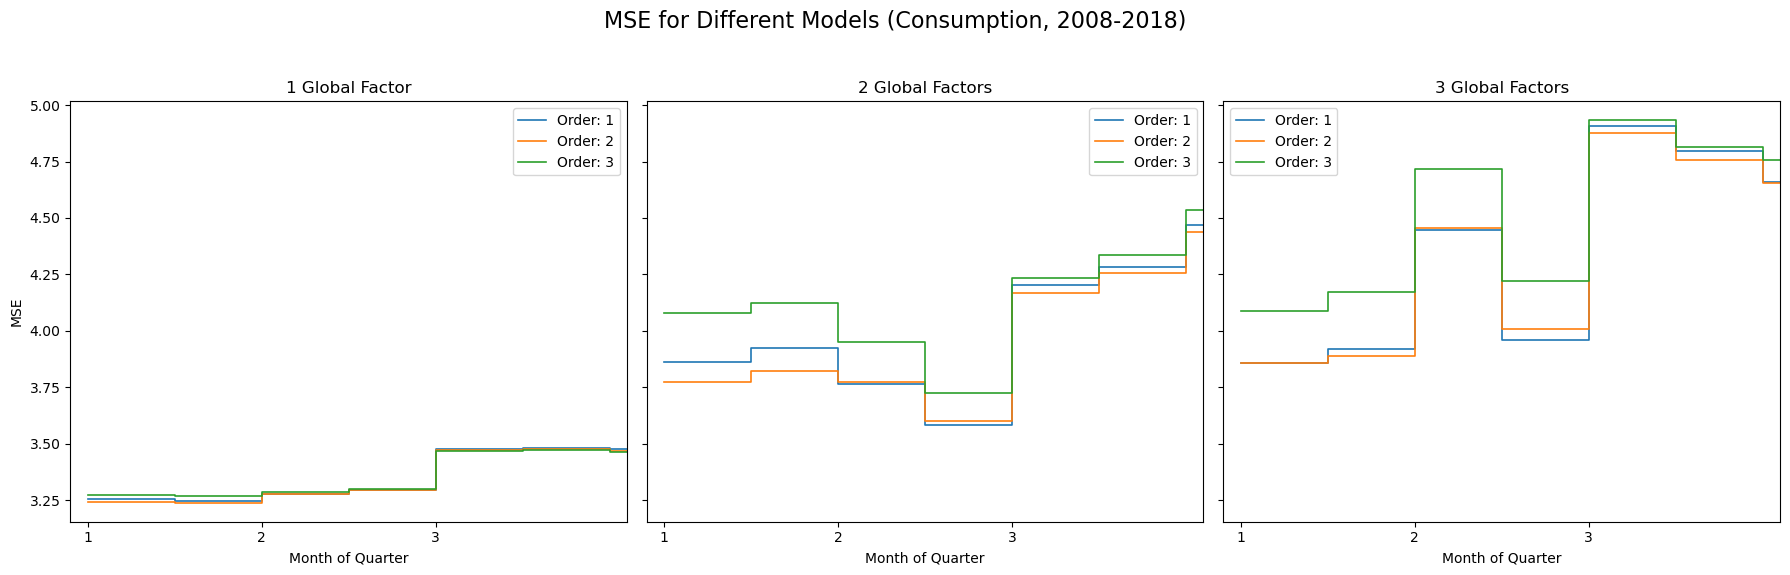

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


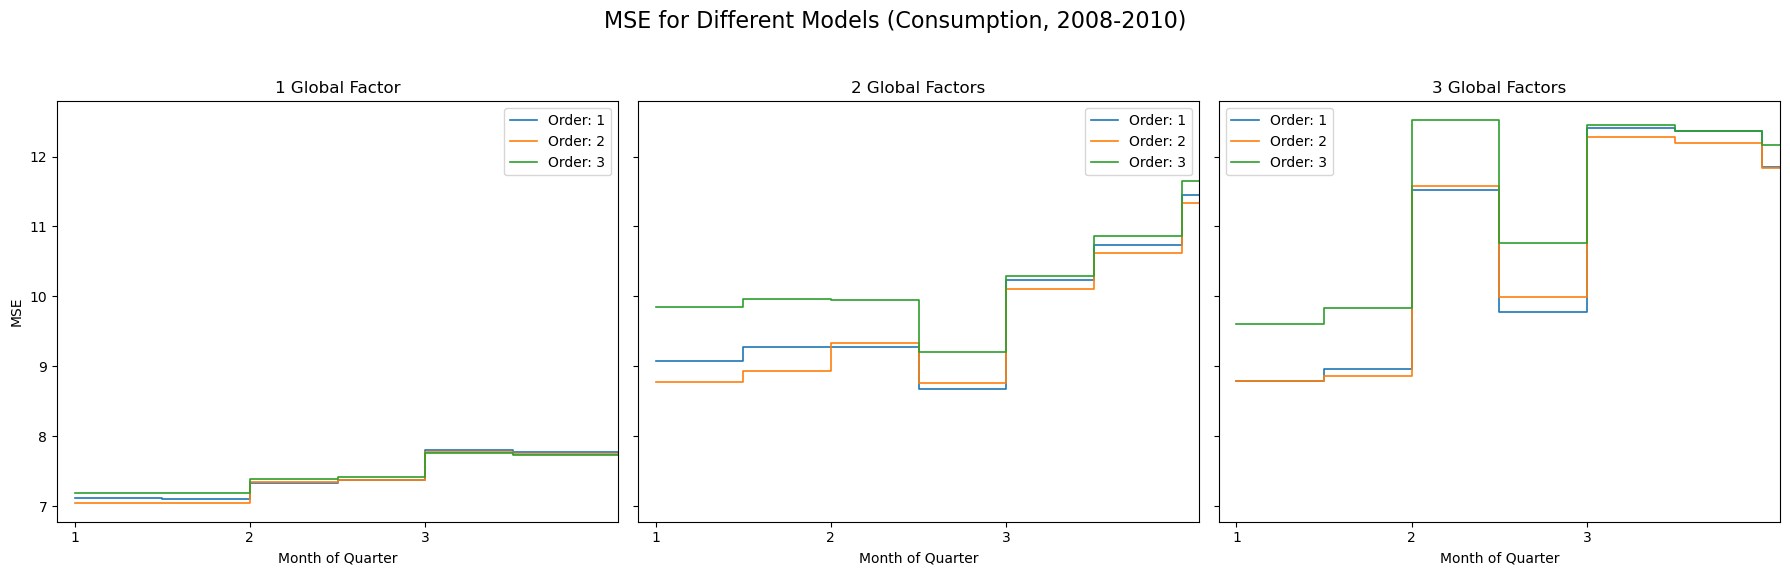

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


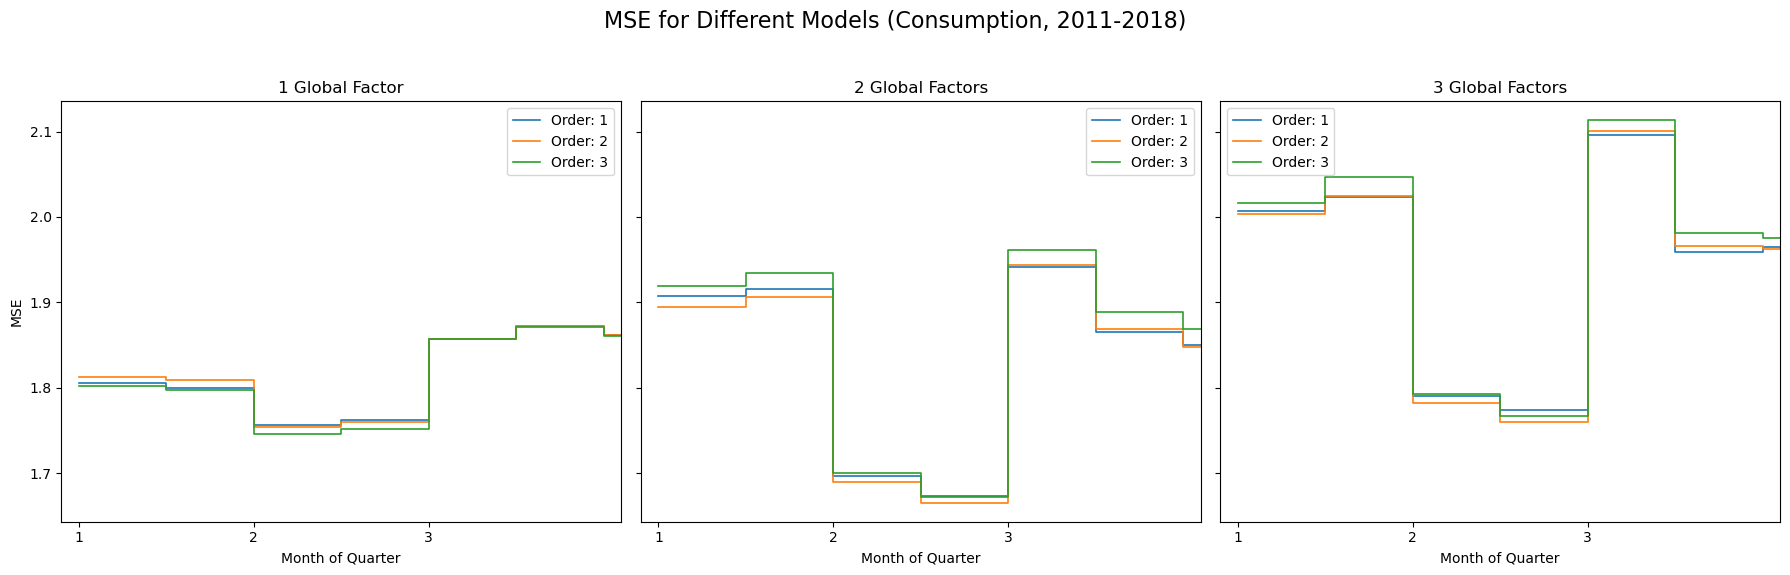

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


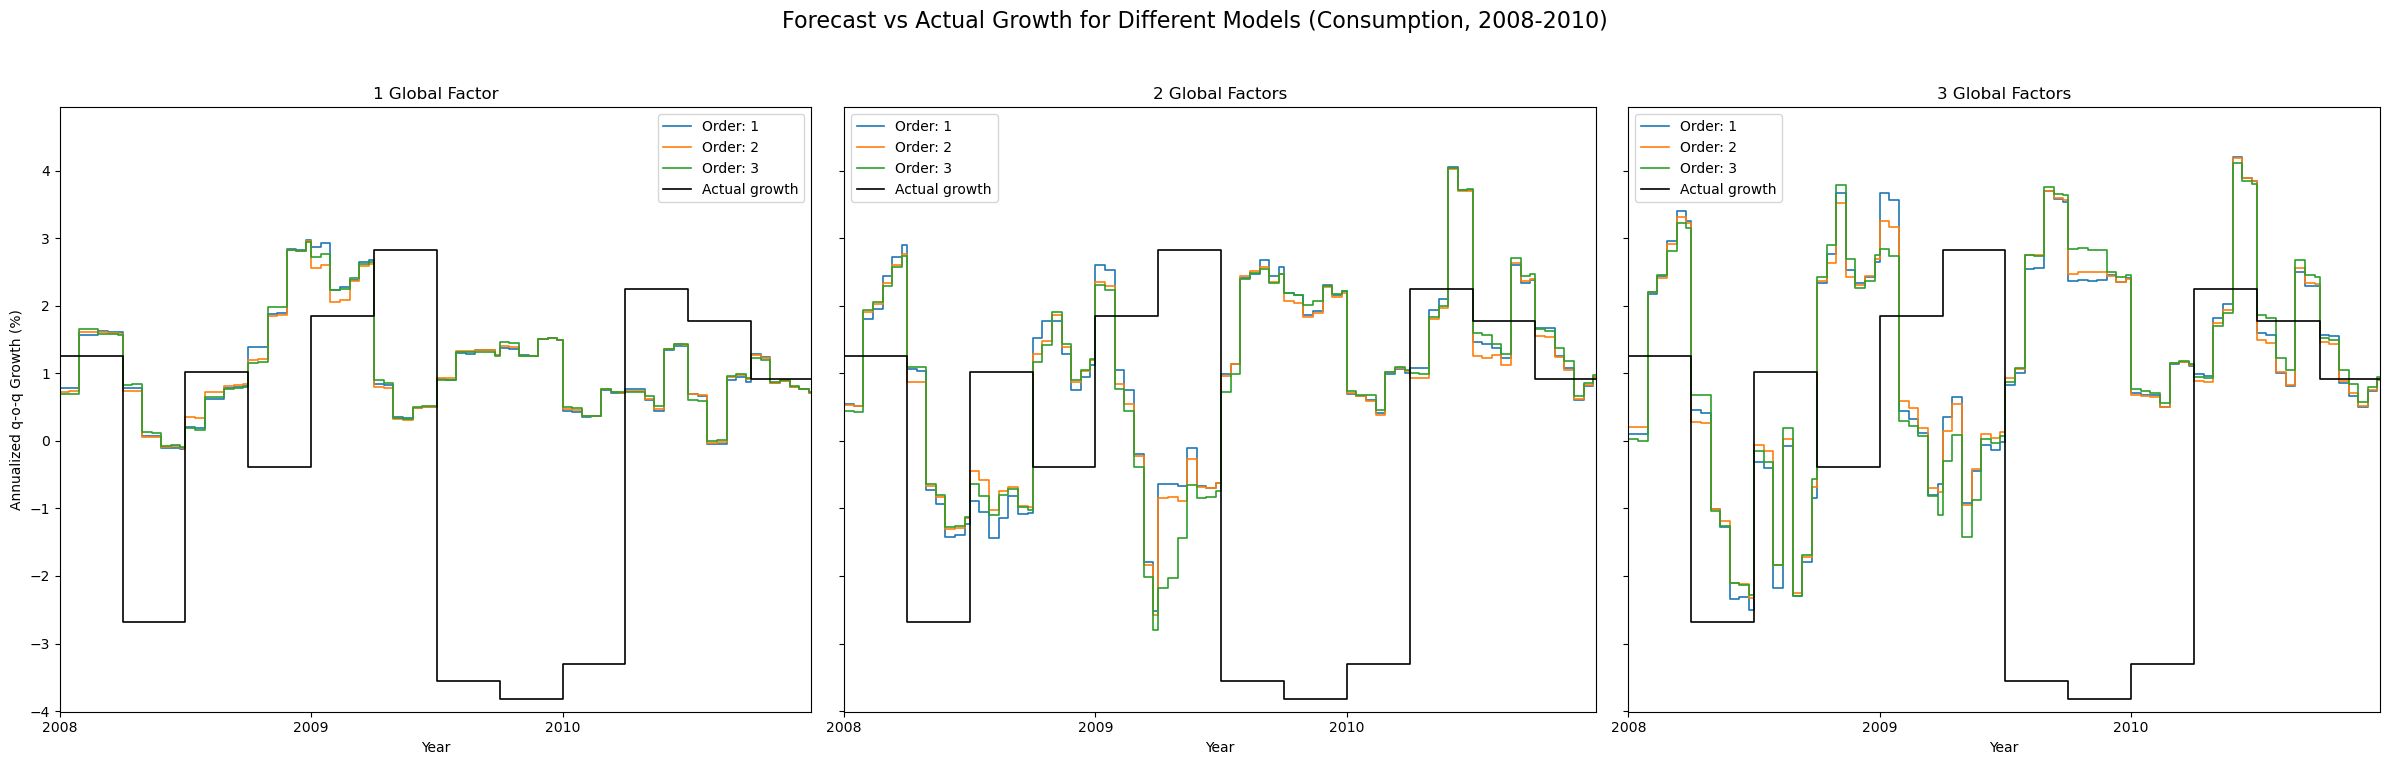

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


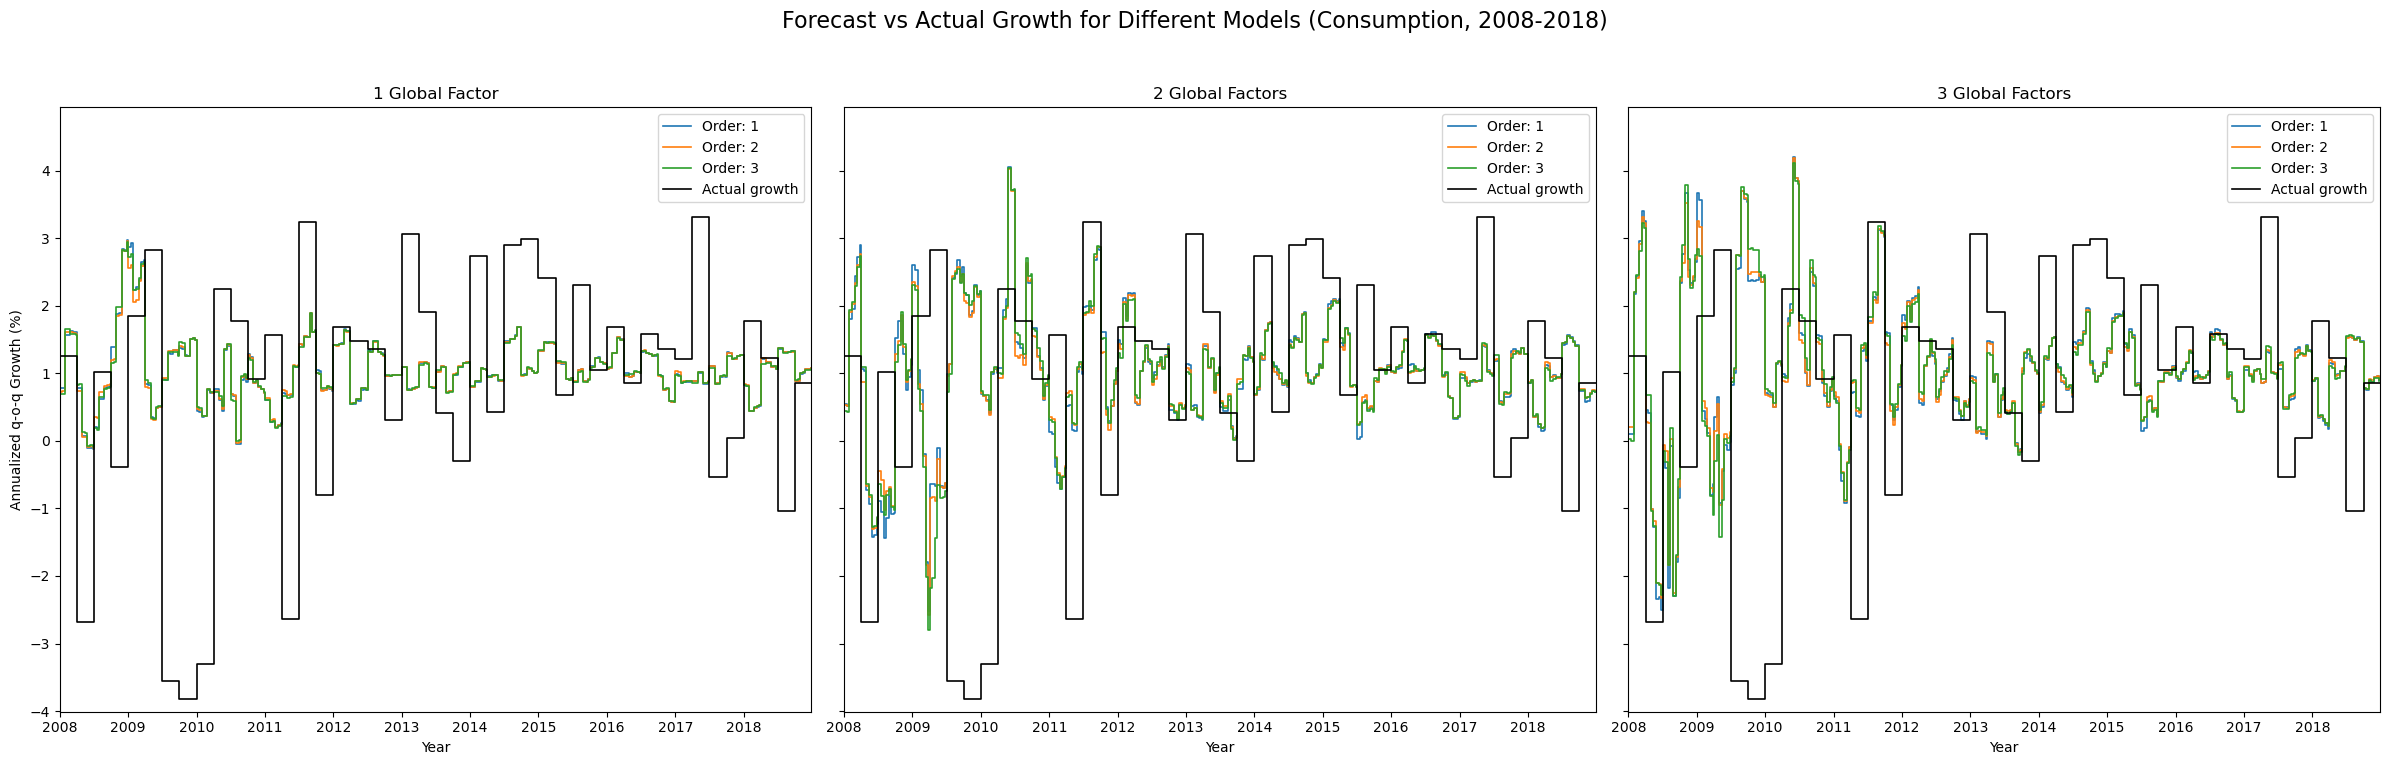

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


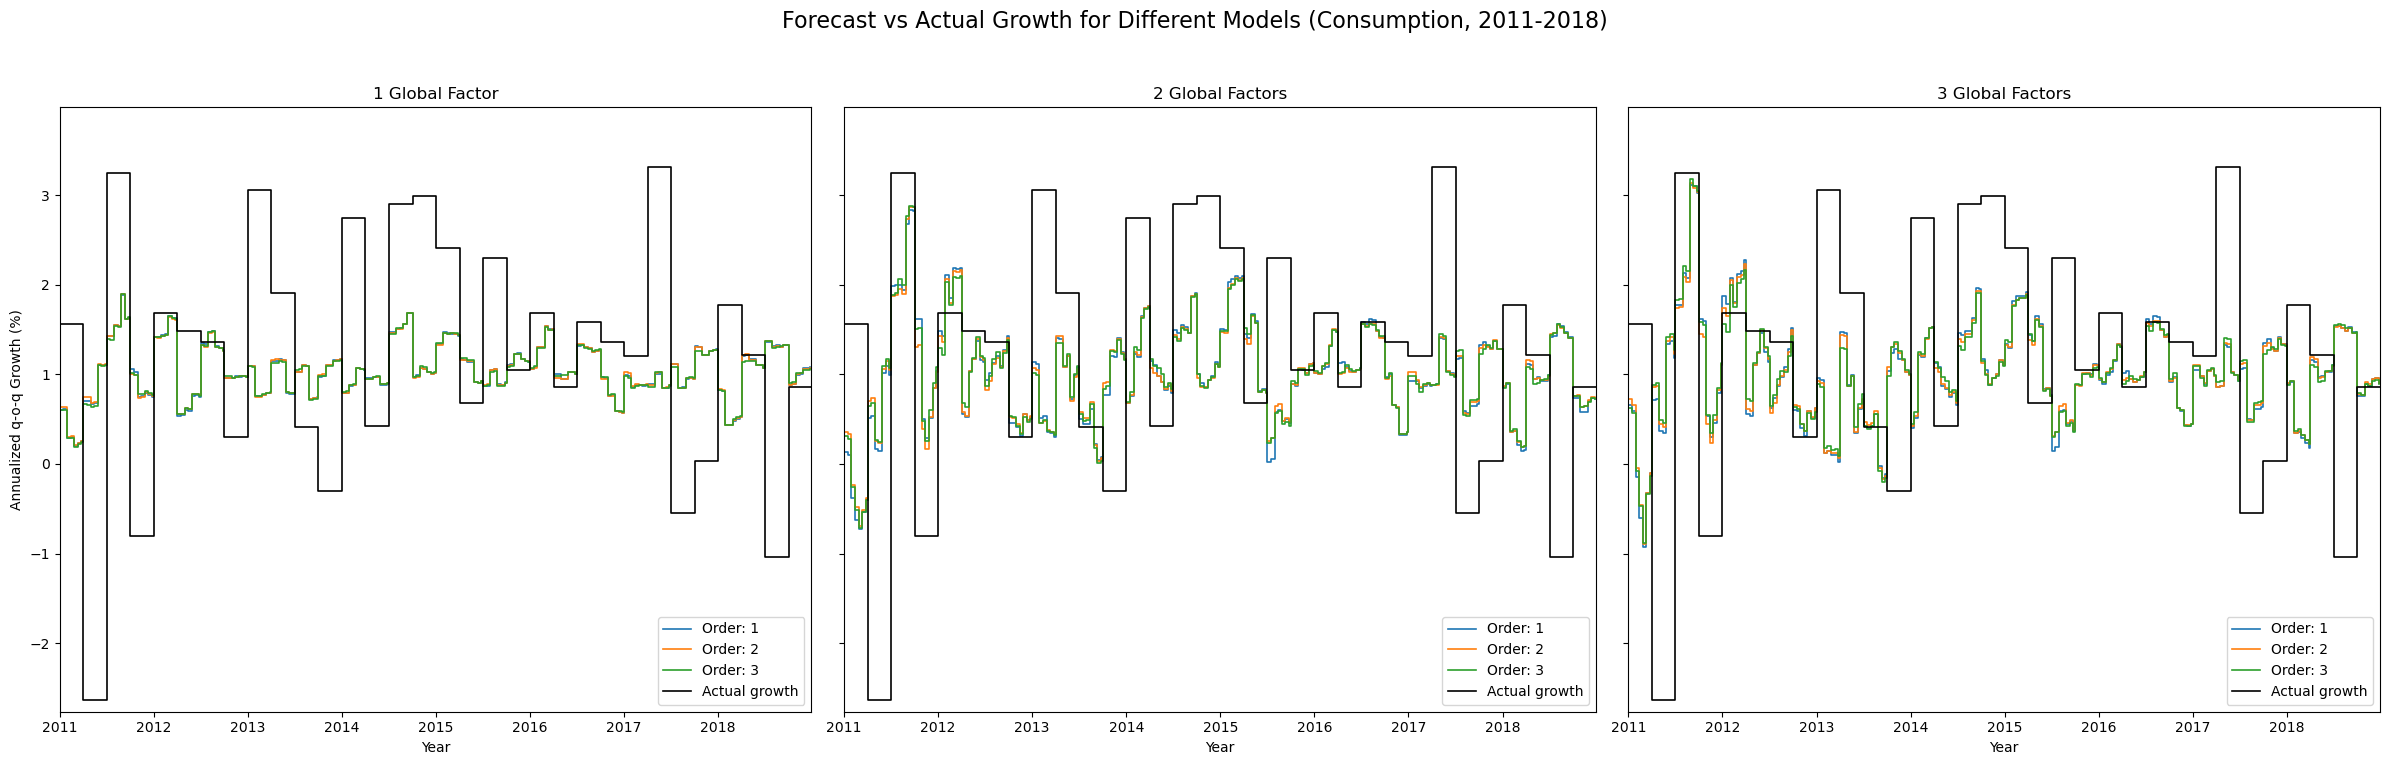

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()